In [1]:
# Copyright (c) 2023 Graphcore Ltd. All rights reserved.

## Evaluation of the auxiliary gamma function

The evaluation of integrals involving a $\frac{1}{r}$ term require computing the following:

$$
\begin{equation}
\tag{1}
F(\nu, t) = \int_0^1 u^{2 \nu} e^{-t u^2} du
\end{equation}
$$

Taketa et al. call this the auxiliary function $F$ and we can show its relationship to the $\gamma$ function with SymPy.
First we build up the integral as stated in equation 2.11 in the THO paper.

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyquante2.utils import Fgamma as reference_pyquante

from functools import partial
from IPython.display import display

sns.set_theme()
%matplotlib inline

In [3]:
u, t = sp.symbols("u t", real=True, nonnegative=True)
nu = sp.Symbol("nu", integer=True, nonnegative=True)
F_nu = sp.Integral(u ** (2 * nu) * sp.exp(-t * u ** 2), (u, 0, 1))
F_nu

Integral(u**(2*nu)*exp(-t*u**2), (u, 0, 1))

Evaluating the integral results in an expression involving the [lower incomplete Gamma function](https://mathworld.wolfram.com/IncompleteGammaFunction.html)

In [4]:
F_nu_expanded = sp.simplify(F_nu.doit())
F_nu_expanded

t**(-nu - 1/2)*lowergamma(nu + 1/2, t)/2

Some implementations will fail at $t=0$, so let's re-evaluate the integral for that special case:

In [5]:
F_nu_expanded_t0 = F_nu.subs(t, 0).doit()
F_nu_expanded_t0

1/(2*nu + 1)

Using `lambdify` we can use SymPy to generate a scipy compatible implementation

In [6]:
F_nu_lambdified = sp.lambdify((nu, t), F_nu_expanded, modules="scipy")
help(F_nu_lambdified)

Help on function _lambdifygenerated:

_lambdifygenerated(nu, t)
    Created with lambdify. Signature:
    
    func(nu, t)
    
    Expression:
    
    t**(-nu - 1/2)*lowergamma(nu + 1/2, t)/2
    
    Source code:
    
    def _lambdifygenerated(nu, t):
        return (1/2)*t**(-nu - 1/2)*gamma(nu + 1/2)*gammainc(nu + 1/2, t)
    
    
    Imported modules:



We might need this lambda implementation later but for now let us see if SymPy can find a simpler way to evaluate this function for the integers 0, 1, 2, 3, ...

In [7]:
for i in range(5):
    display(sp.simplify(F_nu_expanded.subs(nu, i)))

sqrt(pi)*erf(sqrt(t))/(2*sqrt(t))

-exp(-t)/(2*t) + sqrt(pi)*erf(sqrt(t))/(4*t**(3/2))

-exp(-t)/(2*t) - 3*exp(-t)/(4*t**2) + 3*sqrt(pi)*erf(sqrt(t))/(8*t**(5/2))

(-8*t**(5/2) - 20*t**(3/2) - 30*sqrt(t) + 15*sqrt(pi)*exp(t)*erf(sqrt(t)))*exp(-t)/(16*t**(7/2))

(-16*t**(7/2) - 56*t**(5/2) - 140*t**(3/2) - 210*sqrt(t) + 105*sqrt(pi)*exp(t)*erf(sqrt(t)))*exp(-t)/(32*t**(9/2))

This has a whiff of a recurrence but unfortunately SymPy doesn't seem to find it.  Lets see if we can spot the pattern:

In [8]:
f_0 = sp.simplify(F_nu_expanded.subs(nu, 0))
f_0

sqrt(pi)*erf(sqrt(t))/(2*sqrt(t))

In [9]:
f_1 = sp.simplify(1 / (2 * t) * (f_0 - sp.exp(-t)))
f_1

-exp(-t)/(2*t) + sqrt(pi)*erf(sqrt(t))/(4*t**(3/2))

In [10]:
f_2 = sp.simplify(1 / (2 * t) * (3 * f_1 - sp.exp(-t)))
f_2

-exp(-t)/(2*t) - 3*exp(-t)/(4*t**2) + 3*sqrt(pi)*erf(sqrt(t))/(8*t**(5/2))

In [11]:
f_3 = sp.collect(sp.simplify(1 / (2 * t) * (5 * f_2 - sp.exp(-t))), sp.exp(-t))
f_3

(-1/(2*t) - 5/(4*t**2) - 15/(8*t**3))*exp(-t) + 15*sqrt(pi)*erf(sqrt(t))/(16*t**(7/2))

In [12]:
f_4 = sp.simplify(1 / (2 * t) * (7 * f_3 - sp.exp(-t)))
f_4

(-16*t**(19/2) - 14*t**(13/2)*(4*t**2 + 10*t + 15) + 105*sqrt(pi)*t**6*exp(t)*erf(sqrt(t)))*exp(-t)/(32*t**(21/2))

From this, we propose the following recurrence:

$$
\begin{aligned}
\tag{2}
F(0, t) &= \frac{1}{2} \text{erf}(\sqrt{t}) \sqrt{\frac{\pi}{t}} \\
F(\nu, t) &= \frac{1}{2 t} \left( (2\nu - 1) F(\nu - 1, t) - e^{-t} \right)
\end{aligned}
$$

We test this recurrence out by comparing to the earlier lambda implementation derived by SymPy.  We also compare this to the SymPy lambdafy implementation but implement a "safe" version as `Fnu_lambda_safe` which avoids the divide by zero warnings when $t=0$

/localdata/hatemh/poplar-tmp/ipykernel_762453/261164265.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.where(t == 0, 1.0, erf(np.sqrt(t)) * np.sqrt(np.pi / (4 * t)))
/localdata/hatemh/poplar-tmp/ipykernel_762453/261164265.py:4: RuntimeWarning: invalid value encountered in multiply
  return np.where(t == 0, 1.0, erf(np.sqrt(t)) * np.sqrt(np.pi / (4 * t)))
/localdata/hatemh/poplar-tmp/ipykernel_762453/261164265.py:11: RuntimeWarning: divide by zero encountered in divide
  v = 1 / (2 * t) * ((2 * nu - 1) * f_nu(nu - 1, t) - np.exp(-t))
/localdata/hatemh/poplar-tmp/ipykernel_762453/261164265.py:11: RuntimeWarning: invalid value encountered in multiply
  v = 1 / (2 * t) * ((2 * nu - 1) * f_nu(nu - 1, t) - np.exp(-t))


nu = 0 max error = 3.6637359812630166e-15
nu = 1 max error = 1.942890293094024e-16
nu = 2 max error = 3.3306690738754696e-16
nu = 3 max error = 1.6237011735142914e-15
nu = 4 max error = 1.1310397063368782e-14
nu = 5 max error = 9.851147675377092e-14
nu = 6 max error = 1.0467876565556367e-12
nu = 7 max error = 1.3154359546074801e-11
nu = 8 max error = 1.9073770340938268e-10
nu = 9 max error = 3.1344563958257687e-09


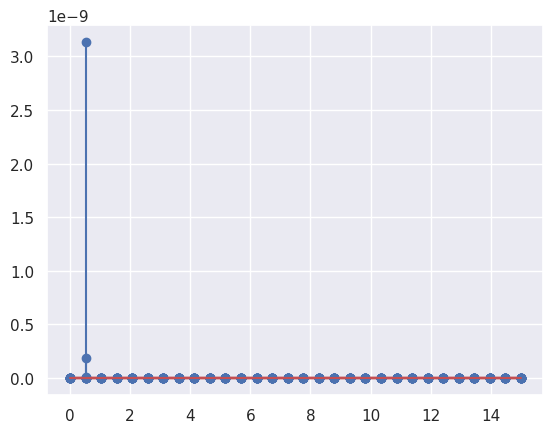

In [13]:
def f_0(t):
    from scipy.special import erf 

    return np.where(t == 0, 1.0, erf(np.sqrt(t)) * np.sqrt(np.pi / (4 * t)))


def f_nu(nu, t, epsilon=1e-10):
    if nu == 0:
        return f_0(t)

    v = 1 / (2 * t) * ((2 * nu - 1) * f_nu(nu - 1, t) - np.exp(-t))
    return np.where(t <= epsilon, 1 / (2 * nu + 1), v)


def Fnu_lambda_safe(nu, t, epsilon=1e-10):
    """nan safe implementation of F_nu_lambdafied"""
    from scipy.special import gammainc, gammaln

    te = np.maximum(t, epsilon)
    v = np.exp(
        np.log(0.5)
        - (nu + 0.5) * np.log(te)
        + np.log(gammainc(nu + 0.5, te))
        + gammaln(nu + 0.5)
    )
    return np.where(t <= epsilon, 1 / (2 * nu + 1), v)
  
x = np.linspace(0, 15, 30)

for n in range(10):
    y1 = f_nu(n, x)
    y2 = Fnu_lambda_safe(n, x)
    e = np.abs(y1 - y2)
    print(f"nu = {n} max error = {e.max()}")
    plt.stem(x, e)

plt.show()


## Boost Math

The boost math library contains a comprehensive implementation of the four different different variants of the gamma function.  For consistent definitions we follow their notation repeated here:



1. The lower incomplete gamma function of $a$ and $z$
$$
\begin{equation}
\tag{3}
\gamma(a, z) = \int_0^z t^{a-1} e^{-t} dt
\end{equation}
$$ 

2. normalised lower incomplete gamma function of $a$ and $z$.  This definition is consistent with the [scipy.special.gammainc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gammainc.html) implementation
$$
\begin{equation}
\tag{4}
P(a, z) = \frac{\gamma(a, z)}{\Gamma(a)} = \frac{1}{\Gamma(a)} \int_0^z t^{a-1} e^{-t} dt
\end{equation}
$$

3. upper incomplete gamma function of $a$ and $z$.
$$
\begin{equation}
\tag{5}
\Gamma(a, z) = \int_z^\infty t^{a-1} e^{-t} dt
\end{equation}
$$

4. normalised upper incomplete gamma function of $a$ and $z$. This definition is consisent with the [scipy.special.gammaincc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gammaincc.html) implementation
$$
\begin{equation}
\tag{6}
Q(a, z) = \frac{\Gamma(a, z)}{\Gamma(a)} = \frac{1}{\Gamma(a)} \int_z^\infty t^{a-1} e^{-t} dt
\end{equation}
$$

An additional identiy that follows from the integral definition:
$$
\begin{equation}
\tag{7}
\gamma(a, z) + \Gamma(a, z) = \Gamma(a)
\end{equation}
$$
and for the normalised functions we have:
$$
\begin{equation}
\tag{8}
P(a, z) + Q(a, z) = 1
\end{equation}
$$

Back to the boost libary, see [#10](https://beta.boost.org/doc/libs/1_82_0/libs/math/doc/html/math_toolkit/sf_gamma/igamma.html#math_toolkit.sf_gamma.igamma.implementation) of their implementation notes which states for half-integers $a \in [\frac{1}{2}, 30]$ that the following series expansion should be used to evaluate the upper incomplete regularised gamma function:
$$
\begin{equation}
\tag{9}
Q(a, x) = \text{erfc}(\sqrt{x}) + \frac{e^{-x}}{\sqrt{\pi x}} \sum_{n=1}^{a - \frac{1}{2}} \frac{x^n}{(1 - \frac{1}{2}) \cdots (n - \frac{1}{2})}
\end{equation}
$$




In [14]:
def g(a, x):
    from scipy.special import erfc, gamma

    term = np.exp(-x) / np.sqrt(np.pi * x)
    q = erfc(np.sqrt(x))

    for n in range(1, int(a + 0.5)):
        term /= n - 0.5
        term *= x
        q += term

    return (1 - q) * gamma(a)

def gv(a, x, amax=30):
    from scipy.special import erfc, gamma

    n = np.arange(1, amax + 1)
    mask = n <= a
    q = erfc(np.sqrt(x))
    q += np.exp(-x) / np.sqrt(np.pi * x) * np.sum(mask * x ** n / np.cumprod(n - 0.5))

    return (1 - q) * gamma(a)

def og(a, x):
    from scipy.special import gammainc, gammaln

    return np.exp(gammaln(a) + np.log(gammainc(a, x)))
    
def pq(a, x):
    from pyquante2.utils import gamm_inc

    return gamm_inc(a, x)

x = 1.0
for prev_a in range(20):
    abs_error = np.abs(og(prev_a + 0.5, x) - g(prev_a + 0.5, x))
    rel_error = abs_error / og(prev_a + 0.5, x)
    print(abs_error, rel_error)


6.661338147750939e-16 4.459776977656937e-16
1.6653345369377348e-16 4.3946638485055916e-16
2.220446049250313e-16 1.107246765857766e-15
4.163336342344337e-16 3.1194323558338866e-15
2.2620794126737565e-15 2.2792539957273192e-14
1.2420620087993939e-14 1.5776276943287004e-13
6.49896803039951e-14 9.977832158152448e-13
3.554517791215517e-13 6.405459416834582e-12
2.5983729057266203e-12 5.3784749837562836e-11
1.7344348179904046e-11 4.0561555937670355e-10
1.4016347804624019e-10 3.6552429262447314e-09
1.069651311969011e-09 3.077936926389166e-08
1.255947506412225e-08 3.9531191153418467e-07
9.648126094580212e-08 3.2975236827047864e-06
1.2419848460266947e-06 4.580767701633588e-05
1.7948268090407782e-05 0.0007105560037904496
1.7915769273919163e-05 0.0007577831080872898
0.0032044584860772968 0.14421996957159758
0.020957303649203077 1.0
0.01983067633881408 1.0


## Series evaluation of lower incomplete gamma function

The special case above appears to have excessive errors as `a` increases. We can instead try the standard series expansion method:
$$
\begin{equation}
\tag{10}
\gamma(a, z) = z^a e^{-z} \sum_{k=0}^{\infty} \frac{\Gamma(a)}{\Gamma(a + k + 1)} z^k
\end{equation}
$$
See [#4](https://beta.boost.org/doc/libs/1_82_0/libs/math/doc/html/math_toolkit/sf_gamma/igamma.html#math_toolkit.sf_gamma.igamma.implementation) on the boost documentation which also shows how this series can be simplfied to:
$$
\begin{equation}
\tag{11}
\gamma(a, z) = z^a e^{-z} \sum_{k=0}^{\infty} \frac{z^k}{a^{\overline{k + 1}}}
\end{equation}
$$
by using the recursion relation:
$$
\begin{equation}
\tag{12}
\Gamma(z+1) = z \Gamma(z)
\end{equation}
$$
where we use $a^{\overline{k + 1}}$ as the [Pochhammer symbol](https://en.wikipedia.org/wiki/Falling_and_rising_factorials) evaluated as:
$$
\begin{equation}
\tag{13}
a^{\overline{k + 1}} = a(a + 1)(a+2) \cdots (a + k)
\end{equation}
$$

This can be used to build a log-space implementation of the lower incomplete gamma function.

In [15]:
def gammaincln_loop(a: float, z: float, num_terms=32, epsilon=1e-10):
    """Lower incomplete gamma function computed from series representation in log-space

    Should be equivalent to:

        import numpy as np
        from scipy.special import gammainc, gammaln

        gammaln(a) + np.log(gammainc(a, z))
    """
    a0 = a
    term = 1 / a
    total = 0.0

    for _ in range(num_terms):
        a += 1
        term *= z / a
        total += term

    total += 1 / a0
    z = max(z, epsilon)
    return a0 * np.log(z) - z + np.log(total)


def gammaincln_vec(a, z, num_terms=32, epsilon=1e-10, dtype=np.float64):
    ak = a + np.arange(num_terms, dtype=dtype)
    zk = np.full(ak.shape, z, dtype=dtype)
    zk[0] = 1.0
    total = np.sum(np.cumprod(zk / ak))
    z = np.maximum(z, epsilon)
    return a * np.log(z) - z + np.log(total)


gammaincln = gammaincln_vec


def reference_scipy(a, z):
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gammainc.html
    from scipy.special import gammaln, gammainc

    return gammaln(a) + np.log(gammainc(a, z))


def reference_mpmath(a, z):
    # https://mpmath.org/doc/current/functions/expintegrals.html#gammainc
    from mpmath import gammainc, log

    return float(log(gammainc(float(a), b=float(z))))


prev_a = 1.5
z = 10.0

ref_sp = reference_scipy(prev_a, z)
ref_mp = reference_mpmath(prev_a, z)
ans = gammaincln(prev_a, z, 64)
abs((ref_sp - ans) / ref_sp), abs((ref_mp - ans) / ref_mp)

(3.327401488179459e-15, 3.556877452881491e-15)

How many terms need to be evaluated to converge?

In [16]:
A = np.arange(0, 16, 4) + 0.5
Z = np.linspace(0, 20, 5)
N = np.array([32, 64, 128])

vals = np.meshgrid(A, Z, N)
A, Z, N = [t.reshape(-1) for t in vals]

gammaincln_fp64 = partial(gammaincln, dtype=np.float64)
gammaincln_fp32 = partial(gammaincln, dtype=np.float32)
actual_fp64 = np.vectorize(gammaincln_fp64)(A, Z, N)
actual_fp32 = np.vectorize(gammaincln_fp32)(A, Z, N)
expect = reference_scipy(A, np.maximum(Z, 1e-10))

df = pd.DataFrame(
    {
        "a": A,
        "z": Z,
        "num_terms": N,
        "actual_fp64": actual_fp64,
        "actual_fp32": actual_fp32,
        "expect": expect,
    }
)
df["rel_error_fp64"] = np.abs((df.actual_fp64 - df.expect) / df.expect)
df["abs_error_fp64"] = np.abs(df.actual_fp64 - df.expect)
df["rel_error_fp32"] = np.abs((df.actual_fp32 - df.expect) / df.expect)
df["abs_error_fp32"] = np.abs(df.actual_fp32 - df.expect)

df.head()

,a,z,num_terms,actual_fp64,actual_fp32,expect,rel_error_fp64,abs_error_fp64,rel_error_fp32,abs_error_fp32
0,0.5,0.0,32,-10.819778,-10.819778,-10.819778,6.161556e-12,6.666667e-11,1.698729e-10,1.837988e-09
1,0.5,0.0,64,-10.819778,-10.819778,-10.819778,6.161556e-12,6.666667e-11,1.698729e-10,1.837988e-09
2,0.5,0.0,128,-10.819778,-10.819778,-10.819778,6.161556e-12,6.666667e-11,1.698729e-10,1.837988e-09
3,4.5,0.0,32,-105.120407,-105.120407,-105.120407,1.729035e-13,1.817568e-11,3.594136e-10,3.778170e-08
4,4.5,0.0,64,-105.120407,-105.120407,-105.120407,1.729035e-13,1.817568e-11,3.594136e-10,3.778170e-08


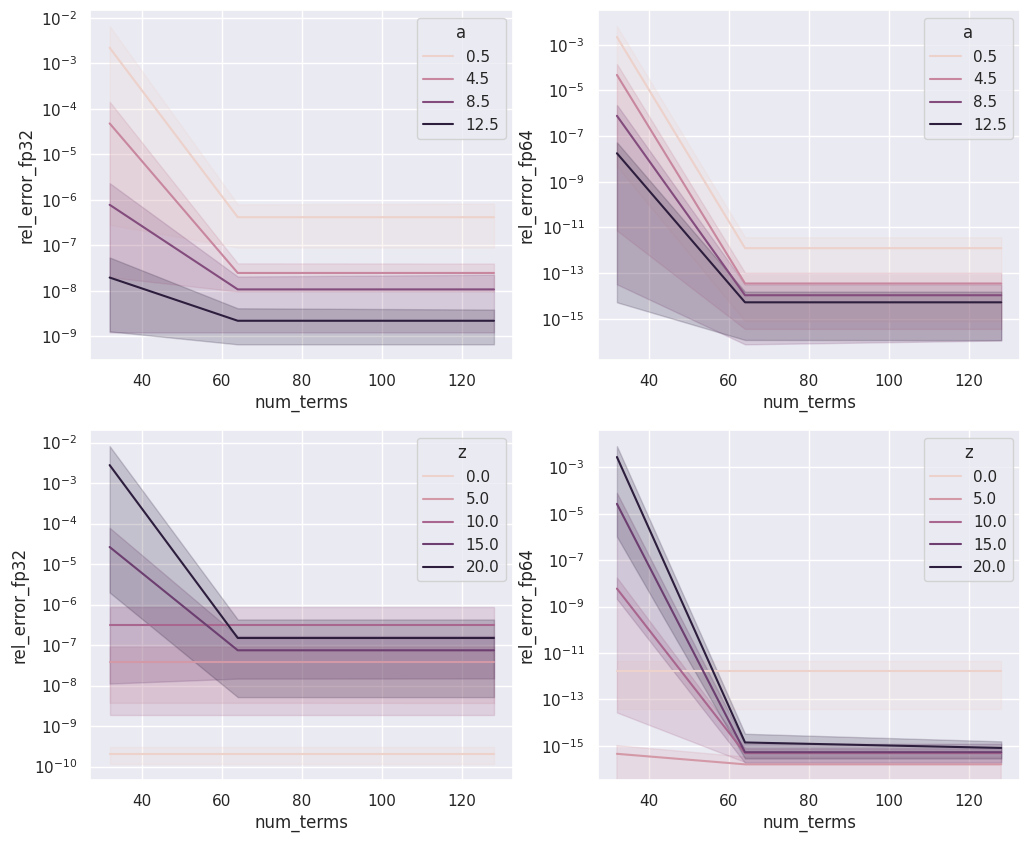

In [17]:
_, ax = plt.subplots(2, 2, figsize=(12, 10), )
sns.lineplot(ax=ax[0, 0], data=df, x="num_terms", y="rel_error_fp32", hue="a")
sns.lineplot(ax=ax[0, 1], data=df, x="num_terms", y="rel_error_fp64", hue="a")
sns.lineplot(ax=ax[1, 0], data=df, x="num_terms", y="rel_error_fp32", hue="z")
sns.lineplot(ax=ax[1, 1], data=df, x="num_terms", y="rel_error_fp64", hue="z")

for prev_a in ax.flat:
    prev_a.set(yscale="log")


## Combining series evaluation with $F(\nu, t)$ 

Remember from earlier that goal is to evaluate:
$$
\begin{equation}
\tag{14}
F(\nu, t) = \int_0^1 u^{2 \nu} e^{-t u^2} du
\end{equation}
$$
which we used SymPy to show that
$$
\begin{equation}
\tag{15}
F(\nu, t) = \frac{1}{2} t^{-\nu - \frac{1}{2}} \gamma(\nu + \frac{1}{2}, t)
\end{equation}
$$
now combining this result with the series representation for the lower incomplete gamma function:
$$
\begin{equation}
\tag{16}
\gamma(\nu + \frac{1}{2}, t) = t^{\nu + \frac{1}{2}} e^{-t} \sum_{k=0}^{\infty} \frac{t^k}{(\nu + \frac{1}{2})^{\overline{k+1}}}
\end{equation}
$$
we arrive at:
$$
\begin{equation}
\tag{17}
F(\nu, t) = \frac{e^{-t}}{2} \sum_{k=0}^{\infty} \frac{t^k}{(\nu + \frac{1}{2})^{\overline{k+1}}}
\end{equation}
$$
recall that $a^{\overline{k + 1}}$ is the [Pochhammer symbol](https://en.wikipedia.org/wiki/Falling_and_rising_factorials) evaluated as:
$$
\begin{equation}
\tag{18}
a^{\overline{k + 1}} = a(a + 1)(a+2) \cdots (a + k)
\end{equation}
$$
which leads to a simple recurrence that can be used to evaluate the series:
$$
\begin{aligned}
\tag{19}
a &\equiv \nu + \frac{1}{2} \\ 
f_0 &= \frac{1}{a}\\
f_k &= \frac{t}{a + 1} f_{k-1} \\
F(\nu, t) &= \frac{e^{-t}}{2} \sum_{k=0}^{\infty} f_k 
\end{aligned}
$$
This series will converge as $k \rightarrow \infty$ since the denominator terms will grow faster then the numerator. 
In practice the number of terms needed to converge should be expected to be similar to the study above for the convergence of the lower incomplete gamma function in log space.

As a sanity check we can see that the $t=0$ case agrees with evaluation of the integral:
$$
\tag{20}
F(\nu, 0) = \frac{1}{2 \nu + 1}
$$
without resorting to any special casing to avoid a singularity as $t \rightarrow 0$ that is inherent in Equation 15.

In [18]:
def Fnut(nu, t, num_terms=128):
    a = nu + 0.5
    total = 1 / a
    term = 1 / a

    for _ in range(num_terms):
        a += 1
        term *= t / a
        total += term

    return np.exp(-t) / 2 * total


nu = 0.0
t = 0.0

abs((Fnut(nu, t) - reference_pyquante(nu, t)) / reference_pyquante(nu, t))


3.331779296901205e-13

This absolute error is a little misleading since the special case of $\nu=t=0$ should be handled correctly by `Fnut`:

In [19]:
Fnut(nu, t), reference_pyquante(nu, t)

(1.0, 0.9999999999996668)

nu = 0 max error = 3.885780586188048e-15
nu = 1 max error = 5.551115123125783e-17
nu = 2 max error = 4.163336342344337e-17
nu = 3 max error = 3.642919299551295e-17
nu = 4 max error = 4.85722573273506e-17
nu = 5 max error = 7.632783294297951e-17
nu = 6 max error = 5.551115123125783e-17
nu = 7 max error = 3.469446951953614e-17
nu = 8 max error = 1.3877787807814457e-17
nu = 9 max error = 4.163336342344337e-17


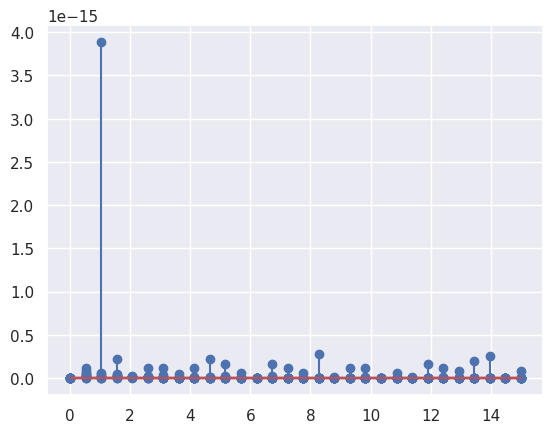

In [20]:
x = np.linspace(0, 15, 30)

for n in range(10):
    y1 = Fnut(n, x)
    y2 = Fnu_lambda_safe(n, x)
    e = np.abs(y1 - y2)
    print(f"nu = {n} max error = {e.max()}")
    plt.stem(x, e)